В этом ноутбуке будем обучать LoRA под Stable Diffusion v1.5 на скриншотах из игры Road 96, чтобы получить уникальную стилистику.

Скриншоты из игры были взяты с различных онлайн-форумов и обрезаны до разрешения 768x768.



# Загрузка изображений

In [1]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("Outrun32/road96screenshots")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.3 MB/s eta 0:00:00


Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Импорт всех библиотек

In [2]:
from PIL import Image
import torch
import numpy as np
import random
import os

## Посмотрим на изображения


In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Возьмем первые 8 изображений

In [4]:
grid = image_grid(dataset['train'][:8]['image'], 1, 8)

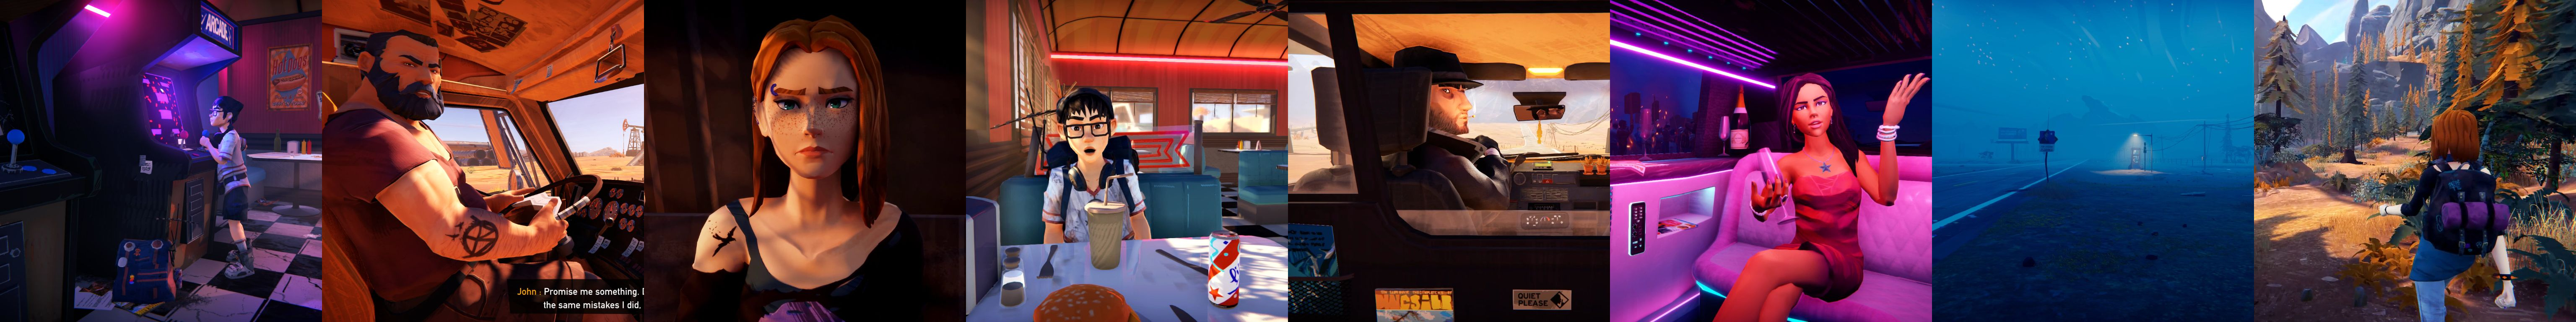

In [5]:
grid

Возможный минус в том, что изображения слегка отличаются по стилю, но я старался подбирать наиболее разнообразные сцены из игры, для того чтобы модель лучше генерализировалась на этом стиле.

Сохраняем изображения в папке


In [6]:
!mkdir train_data
for i, img in enumerate(dataset['train'][:]['image']):
  img.save(f"train_data/{i}.png")

# Установка библиотек
Из-за бага, нужно будет установить версию diffusers 0.14.0

In [ ]:
!pip install diffusers==0.14.0
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
!pip install accelerate bitsandbytes

## Фиксирование seed

In [16]:
def setup_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.backends.cudnn.deterministic = True
generator = torch.Generator("cuda").manual_seed(1)

In [9]:
setup_seed(1)

# TRAINING

In [25]:
import os
import shutil
from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="a landscape of a lake with mountains in background, 1road96 style" #@param{type: 'string'}

OUTPUT_DIR="road96_style" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="train_data" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

Поскольку блокнот старый, то библиотека Accelerate уже обновилась и параметр logging_dir, не распознается.
Чтобы пофиксить нужно открыть файл
lora/training_scripts/train_lora_dreambooth.py
и на строке 492 заменить


```
logging_dir=logging_dir,
```
на
```
project_dir=logging_dir
```



## Параметры при обучении


Для демонстрации, попробуем оставить все параметры со статьи (хоть мы и тренируем стиль), однако поставим количество шагов на 500. \

In [ ]:
STEPS = 500 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 5e-6 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 3e-4 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

# INFERENCE

In [2]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale, patch_pipe
from diffusers import StableDiffusionPipeline

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])
pipe.safety_checker = None

LORA_SCALE_UNET и LORA_SCALE_TEXT_ENCODER говорят о том на какой коэффицент домножаются обученные матрицы Unet и Text encoder (CLIP) соответсвенно. В случае если мы хотим использовать обученный стиль полностью, то лучше ставить оба значения на 1.0. Guidance Scale (насколько денойзинг следует промпту) принято ставить на 7.5.

  0%|          | 0/50 [00:00<?, ?it/s]

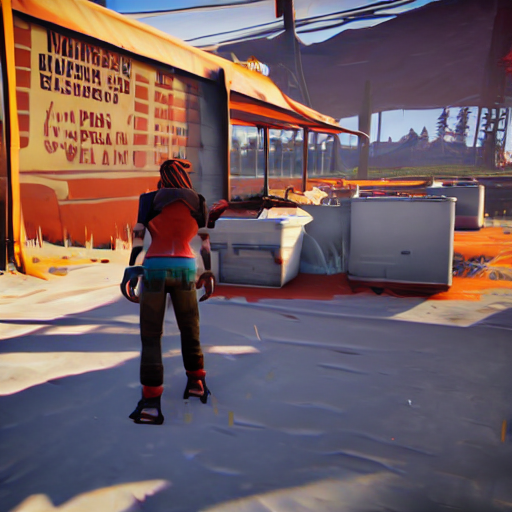

In [36]:
INFERENCE_PROMPT = 'a beautiful landscape of lake and mountains, 1road96 style' #@param {type:"string"}
LORA_SCALE_UNET = 1.0 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1.0 #@param {type:"number"}
GUIDANCE = 8 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

Судя по всему модель переобучилась на изображениях с Training Set'а и выдает рандомные изображения, как то напоминающие встречающиеся в датасете. Оно и понятно, ведь фактически мы никаких параметров специфических для обучения стиля не меняли. Мы также не использовали промпты при обучении, а просто задали 1road96 style как instance и class промпт. Давайте сделаем другой подход к обучению.

clear_gpu() нужен для того чтобы у нас удалялась используемая память с gpu и можно было начинать обучение / inference на новом пайплайне

In [33]:
import gc
def clear_gpu(pipe):
  pipe.to('cpu')
  del pipe
  gc.collect()
  torch.cuda.empty_cache()

В репозитории cloneofsimo/lora (том, который используется сейчас) есть целый набор скриптов, которыми можно обучать модель. Одним из способов обучения является lora_pti (Pivotal tuning inversion). Он заключается в использовании и LoRA и Textual Inversion одновременно. Textual Inversion используется для получения эмбеддинга токена, которым будет описываться стиль. А затем, этот эмбеддинг и prior-preserving loss используются для обучения самой модели. Таким образом, обучение происходит в два этапа:


1.   Textual Inversion - placeholder tokens обновляются градиентами при обучении, и хранят в себе информацию о стиле.
2.   LoRA - С уже обучеными placeholder tokens мы обучаем LoRA.



Давайте пройдемся по параметрам при обучении, которые я считаю важно выделить.



*   train_text_encoder - меняем ли мы веса текстового энкодера при обучении
*   gradient_accumulation_steps - по сути, через сколько батчей мы меняем веса при обучении (*но я не уверен, т.к. в репозитории про это не сказано*)
*   lr_scheduler - В нашем случае linear, так как для каждого обучаемого компонента мы не меняем learning rate во время обучения.
*   placeholder_tokens - насколько я понял, это обучаемые токены при Textual Inversion этапе обучения. Два токена позволяют использовать два обучаемых вектора. При начале обучения эти векторы инициализируются рандомно, а потом обновляются градиентами. Я не уверен почему в примере используются два токена s1s2, но по моей личной практике и по комментариям с форума, оно работает лучше чем один токен.
*   use_template="style" - благодаря этому темплэйту перед обучением у нас для каждого изображения в трэйнинг сэте создается caption в котором используется placeholder tokens (к примеру, "a dark painting in style s1s2" и т.д.). Это позволяет модели учить только placeholder токены и запоминать стиль изображений вне зависимости от их содержания и объектов. (*Хотя это, возможно, не лучший подход, так как в наиболее часто используемом способе fine-tuning'а kohya генерируются captions для описания содержимового изображений*)
*   perform_inversion - Этот флаг говорит нужно ли обучать Textual Inversion токены или нет, если он False, то обучение сразу переходит к 2-му этапу LoRA
*   lora_rank - размер обучаемой матрицы LoRA, почему-то на civitai любят ставить 128, но по моей практике небольшие значения показывают себя не хуже.








In [16]:
!lora_pti \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="./train_data" \
  --output_dir="./lora_pti_trained" \
  --train_text_encoder \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --scale_lr \
  --learning_rate_unet=1e-4 \
  --learning_rate_text=1e-5 \
  --learning_rate_ti=5e-4 \
  --color_jitter \
  --lr_scheduler="linear" \
  --lr_warmup_steps=0 \
  --placeholder_tokens="<s1>|<s2>" \
  --use_template="style"\
  --save_steps=100 \
  --max_train_steps_ti=1000 \
  --max_train_steps_tuning=1000 \
  --perform_inversion=True \
  --clip_ti_decay \
  --weight_decay_ti=0.000 \
  --weight_decay_lora=0.001\
  --continue_inversion \
  --continue_inversion_lr=1e-4 \
  --device="cuda:0" \
  --lora_rank=4

2023-09-03 17:32:07.375196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
PTI : Initializer Tokens not given, doing random inits
PTI : Placeholder Tokens ['<s1>', '<s2>']
PTI : Initializer Tokens ['<rand-0.017>', '<rand-0.017>']
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Initialized <s1> with random noise (sigma=0.017), empirically 0.001 +- 0.018
Norm : 0.4863
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 49410. This might induce some performance

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
patch_pipe(
    pipe,
    "./lora_pti_trained/final_lora.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

In [18]:
tune_lora_scale(pipe.unet, 1.0)
tune_lora_scale(pipe.text_encoder, 1.0)

  0%|          | 0/50 [00:00<?, ?it/s]

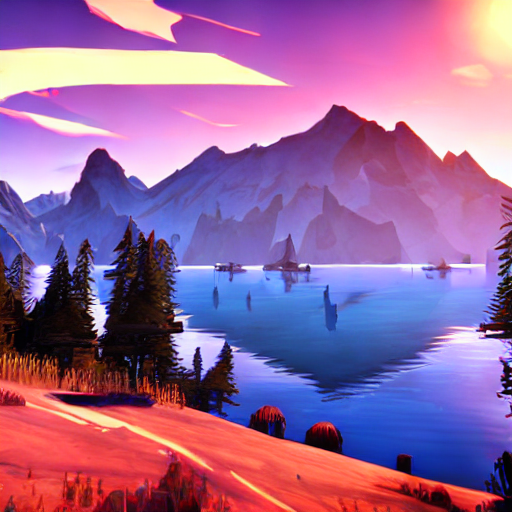

In [24]:
image = pipe("a beautiful landscape with lake and mountains in style of <s1><s2>", num_inference_steps=50, generator=generator).images[0]
image

как можно видеть, результат уже значительно лучше и переобучения чуть меньше. Давайте попробуем запустить инференс на обученной сообществом StableDiffusion, которая лучше с эстетической состовляющей. Мы будем использовать DreamShaper.


In [30]:
clear_gpu(pipe)

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

In [3]:
pipe = StableDiffusionPipeline.from_pretrained("Lykon/DreamShaper", torch_dtype=torch.float16, revision="b3a0cbb4471dad939676da196152d1012e81005b").to("cuda")
patch_pipe(
    pipe,
    "./lora_pti_trained/final_lora.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

safety_checker/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

The config attributes {'addition_embed_type': None, 'addition_embed_type_num_heads': 64, 'class_embeddings_concat': False, 'cross_attention_norm': None, 'encoder_hid_dim': None, 'mid_block_only_cross_attention': None, 'resnet_out_scale_factor': 1.0, 'resnet_skip_time_act': False, 'time_embedding_act_fn': None, 'time_embedding_dim': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or he

<s1>
<s2>


{'<s1>': tensor([ 6.8098e-03, -1.4381e-02,  7.5800e-03, -8.3649e-03,  1.2007e-02,
          9.4955e-03, -2.0726e-03, -3.8103e-04,  1.1089e-02, -1.2791e-02,
         -1.6499e-02,  6.1578e-03,  1.0142e-02,  1.3942e-02,  4.3220e-02,
          1.0875e-02,  1.2977e-02,  2.3843e-02,  1.5182e-02,  3.0060e-02,
         -1.5523e-02,  5.0818e-02, -7.5603e-03, -2.6327e-02,  1.6741e-02,
          1.6212e-02, -3.9799e-02, -4.4461e-03,  1.3204e-02,  1.2670e-02,
         -1.9173e-02, -8.4078e-03,  7.2242e-03,  5.7717e-03, -6.5423e-03,
          8.6831e-04,  1.5810e-02,  3.5117e-02, -3.5508e-03, -1.5265e-02,
         -2.1042e-02, -7.6462e-03, -2.1052e-03, -1.8848e-02,  1.8689e-02,
         -1.1781e-02,  1.7823e-03,  3.5099e-04,  9.8208e-04,  1.5486e-02,
          2.2993e-03, -3.7102e-03,  1.3063e-02, -1.1306e-02, -1.5770e-02,
          1.6980e-02,  9.7227e-03,  1.5715e-02, -1.0474e-03, -1.3540e-02,
          2.1132e-02, -3.0492e-02, -9.4238e-03,  8.1348e-03, -2.7231e-03,
          4.0641e-03, -8.2300e

In [4]:
tune_lora_scale(pipe.unet, 1.0)
tune_lora_scale(pipe.text_encoder, 1.0)

  0%|          | 0/50 [00:00<?, ?it/s]

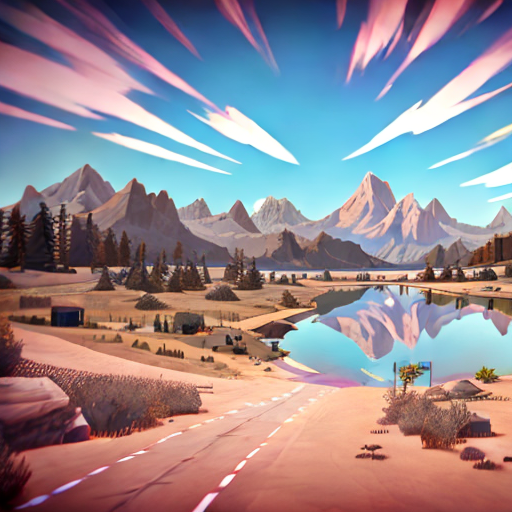

In [31]:
image = pipe("a beautiful landscape with lake and mountains in style of <s1><s2>",
             num_inference_steps=50,
             generator=generator).images[0]
image

Результаты оказались не сильно лучше. Значит, дело всё ещё в обучении. Давайте попробуем обучить с другими гиперпараметрами.

In [35]:
clear_gpu(pipe)

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

Давайте попробуем поставить learning_rate_text_encoder=5e-5, а также попробуем поставить lora_rank=16.

In [44]:
!lora_pti \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="./train_data" \
  --output_dir="./lora_pti_trained_v2" \
  --train_text_encoder \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --scale_lr \
  --learning_rate_unet=1e-4 \
  --learning_rate_text=5e-5 \
  --learning_rate_ti=5e-4 \
  --color_jitter \
  --lr_scheduler="linear" \
  --lr_warmup_steps=0 \
  --placeholder_tokens="<s1>|<s2>" \
  --use_template="style"\
  --save_steps=500 \
  --max_train_steps_ti=500 \
  --max_train_steps_tuning=1000 \
  --perform_inversion=True \
  --clip_ti_decay \
  --weight_decay_ti=0.000 \
  --weight_decay_lora=0.001\
  --continue_inversion \
  --continue_inversion_lr=1e-4 \
  --device="cuda:0" \
  --lora_rank=16

2023-09-03 21:00:45.477790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
PTI : Initializer Tokens not given, doing random inits
PTI : Placeholder Tokens ['<s1>', '<s2>']
PTI : Initializer Tokens ['<rand-0.017>', '<rand-0.017>']
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Initialized <s1> with random noise (sigma=0.017), empirically 0.001 +- 0.018
Norm : 0.4863
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 49410. This might induce some performance

In [52]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
patch_pipe(
    pipe,
    "./lora_pti_trained_v2/final_lora.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension 

<s1>
<s2>


{'<s1>': tensor([ 2.0744e-02, -9.3672e-03, -1.5774e-02, -5.9220e-03, -5.2664e-03,
          3.6815e-02, -1.1266e-02, -1.2820e-02,  5.4981e-03,  4.1261e-03,
          2.2806e-03, -8.1193e-03, -9.2685e-03, -1.7278e-02,  3.5770e-02,
          1.1502e-02,  3.3334e-02,  8.1865e-03,  3.7239e-03,  1.0822e-02,
          4.1825e-03,  4.3099e-02, -5.5631e-03, -1.5550e-02,  1.5509e-02,
          1.2119e-02,  5.3668e-03, -4.7776e-03,  5.1696e-03,  3.2516e-02,
         -1.9383e-02, -6.6040e-03,  3.3961e-03, -2.0934e-02,  1.5152e-02,
          2.2614e-03, -3.1251e-03,  1.2788e-02, -4.2584e-03, -1.1164e-02,
         -3.2815e-02, -7.0168e-03,  2.3911e-02,  2.9736e-03,  2.6000e-02,
         -5.9260e-03,  1.5355e-02,  1.5548e-02, -8.0713e-03,  7.0467e-04,
         -2.1512e-03,  5.5966e-03,  8.4981e-03,  1.3883e-02, -8.8737e-03,
          4.9986e-03, -2.8127e-03, -1.0373e-02, -1.3074e-02,  5.2744e-03,
          1.0945e-02, -3.1288e-02,  4.1303e-03,  9.7762e-03,  1.3163e-02,
         -1.6319e-02, -1.1114e

In [53]:
tune_lora_scale(pipe.unet, 1.0)
tune_lora_scale(pipe.text_encoder, 1.0)

  0%|          | 0/50 [00:00<?, ?it/s]

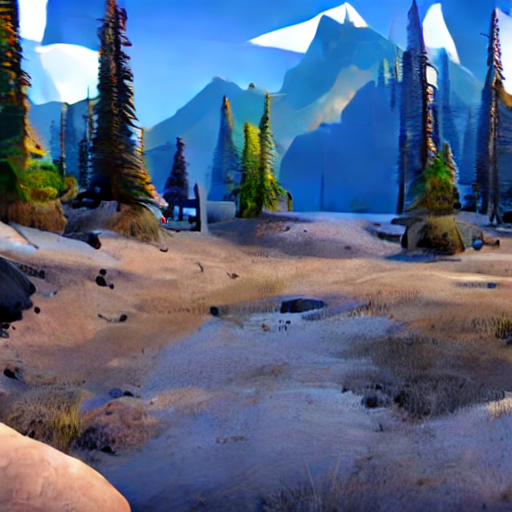

In [54]:
image = pipe("a beautiful landscape with lake and mountains in style of <s1><s2>", num_inference_steps=50, generator=generator).images[0]
image

Почему-то при таких параметрах получаются странные изображения с артефактами.